In [37]:
#pip install pandas numpy scikit-learn matplotlib jupyter

# DAMO-640-10 · Fall 2025  
## Assignment 1 — Supervised Learning (Haberman’s Survival Dataset)

**Student Name:** [Fabio dos Santos Prumucena - NF1002000]  
**Course:** Advanced Data Analytics (DAMO-640)  
**Instructor:** [Ali El-Sharif]   
**Institution:** University of Niagara Falls Canada  
**Public Repository:** [https://github.com/prumucena1979/personalMLTerm4]

---

### Overview
This notebook presents the full implementation of a supervised learning pipeline applied to the *Haberman’s Survival Dataset* as part of Assignment 1. 
The objective is to build, tune, and evaluate predictive models capable of estimating post-surgery survival outcomes in breast cancer patients. 
The following tasks align directly with the assignment requirements and modules 1–4 of the course.

#All imports necessary were concentrated in the cell below

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, classification_report
)

## Task 1 — Data Loading and Exploratory Data Analysis (EDA)

In this first step, the dataset is loaded and its basic characteristics are explored. The four columns—**age**, **operation_year**, **axillary_nodes**, and **survival_status**—are assigned according to the UCI repository description. Summary statistics and the class distribution are analyzed to understand the balance between survivors and non‑survivors.

Potential data issues such as missing values or outliers are examined to ensure the integrity of subsequent analysis. This step lays the foundation for all preprocessing and modeling phases.



In [39]:
# Task 1 — Data Loading & EDA 

# Dataset URL from the assignment
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data"

# Load the CSV directly from the URL (no header) and assign column names
df = pd.read_csv(
    url,
    header=None,
    names=["age", "operation_year", "axillary_nodes", "survival_status"]
)

print(" Dataset loaded successfully from UCI Repository.")
print(f"Shape: {df.shape}")

# Display basic EDA
display(df.head())
display(df.describe())

# Class distribution
print("\nClass counts:")
print(df["survival_status"].value_counts())
print("\nClass ratios:")
print(df["survival_status"].value_counts(normalize=True))

# Check for missing or invalid values
print("\nMissing values per column:")
print(df.isnull().sum())

invalid_years = (df["operation_year"] < 1958) | (df["operation_year"] > 1969)
invalid_nodes = df["axillary_nodes"] < 0

print(f"\nInvalid operation_year rows: {invalid_years.sum()}")
print(f"Invalid axillary_nodes rows: {invalid_nodes.sum()}")


 Dataset loaded successfully from UCI Repository.
Shape: (306, 4)


,age,operation_year,axillary_nodes,survival_status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


,age,operation_year,axillary_nodes,survival_status
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,1.264706
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,60.750000,65.750000,4.000000,2.000000
max,83.000000,69.000000,52.000000,2.000000



Class counts:
survival_status
1    225
2     81
Name: count, dtype: int64

Class ratios:
survival_status
1    0.735294
2    0.264706
Name: proportion, dtype: float64

Missing values per column:
age                0
operation_year     0
axillary_nodes     0
survival_status    0
dtype: int64

Invalid operation_year rows: 306
Invalid axillary_nodes rows: 0


In [40]:
print("Dataset information:")
print(df.info())

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   age              306 non-null    int64
 1   operation_year   306 non-null    int64
 2   axillary_nodes   306 non-null    int64
 3   survival_status  306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB
None


### Sub‑Task 1.1 — Validation of Input Variables

At this stage, the dataset is checked for invalid or inconsistent entries (e.g., operation years outside 1958–1969, or negative node counts). Detecting and handling such anomalies ensures the model learns from accurate and representative data.



In [41]:
print("Records with invalid operation years (outside 1958-1969):")
print(df[~df['operation_year'].between(1958, 1969)])
print("\nRecords with negative axillary nodes:")
print(df[df['axillary_nodes'] < 0])

Records with invalid operation years (outside 1958-1969):
     age  operation_year  axillary_nodes  survival_status
0     30              64               1                1
1     30              62               3                1
2     30              65               0                1
3     31              59               2                1
4     31              65               4                1
..   ...             ...             ...              ...
301   75              62               1                1
302   76              67               0                1
303   77              65               3                1
304   78              65               1                2
305   83              58               2                2

[306 rows x 4 columns]

Records with negative axillary nodes:
Empty DataFrame
Columns: [age, operation_year, axillary_nodes, survival_status]
Index: []


## Task 2 — Preprocessing and Feature Engineering

The variable *survival_status* is converted from {1, 2} into a binary outcome {1 = survived ≥ 5 years, 0 = died < 5 years}. Data are then split into **training (75 %)** and **testing (25 %)** subsets, preserving class proportions when appropriate.

Feature scaling and transformation techniques are applied when needed to improve model convergence and interpretability. The resulting datasets serve as clean inputs for the supervised learning algorithms.



In [42]:
# Compliance Merge — Task 2: Preprocessing (encoding, split 75/25 rs=42, scaling)

# Encode target {1:1, 2:0}
df = df.copy()
df["label"] = df["survival_status"].map({1:1, 2:0})

# Feature–target separation
X = df[["age","operation_year","axillary_nodes"]]
y = df["label"]

# Hold-out split with stratify and fixed seed
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Standardization
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Optional inspection
print("\nBefore standardization (example):")
display(X_train.head())
print("\nAfter standardization (first 5 rows):")
print(pd.DataFrame(X_train_std, columns=X.columns).head())


Before standardization (example):


,age,operation_year,axillary_nodes
15,35,63,0
207,57,67,0
14,35,64,13
126,50,59,0
86,45,64,0



After standardization (first 5 rows):
        age  operation_year  axillary_nodes
0 -1.642926        0.072022       -0.559195
1  0.426339        1.316785       -0.559195
2 -1.642926        0.383213        1.129166
3 -0.232063       -1.172741       -0.559195
4 -0.702351        0.383213       -0.559195


In [43]:
# 1️⃣ Convert survival_status to binary
# In the original dataset: 1 = survived ≥5 years, 2 = died <5 years
df['label'] = df['survival_status'].map({1: 1, 2: 0})
print("Binary label conversion completed.")
print("Label distribution:")
print(df['label'].value_counts().sort_index())

Binary label conversion completed.
Label distribution:
label
0     81
1    225
Name: count, dtype: int64


In [44]:
# 2️⃣ Separate features (X) and label (y)
X = df[['age', 'operation_year', 'axillary_nodes']].copy()
y = df['label'].copy()
print("Features (X) and labels (y) separated successfully.")
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features (X) and labels (y) separated successfully.
Features shape: (306, 3)
Labels shape: (306,)


In [45]:
# 3️⃣ Split into train and test (75/25)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
) 
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (229, 3), Test: (77, 3)


In [46]:
# 4️⃣ Standardize numerical features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
print("Feature standardization completed.")
print(f"Training set mean: {X_train_std.mean(axis=0).round(4)}")
print(f"Training set std: {X_train_std.std(axis=0).round(4)}")

Feature standardization completed.
Training set mean: [-0.  0. -0.]
Training set std: [1. 1. 1.]


In [47]:
# Optional: show before/after to check standardization
print("\nBefore standardization (example):")
display(X_train.head())

print("\nAfter standardization (first 5 rows):")
print(pd.DataFrame(X_train_std, columns=X.columns).head())


Before standardization (example):


,age,operation_year,axillary_nodes
15,35,63,0
207,57,67,0
14,35,64,13
126,50,59,0
86,45,64,0



After standardization (first 5 rows):
        age  operation_year  axillary_nodes
0 -1.642926        0.072022       -0.559195
1  0.426339        1.316785       -0.559195
2 -1.642926        0.383213        1.129166
3 -0.232063       -1.172741       -0.559195
4 -0.702351        0.383213       -0.559195


## Task 3 — Model Training and Dimensionality Reduction

Multiple models are tested to determine which best captures survival patterns. Here, both **Decision Tree (DT)** and **Logistic Regression (LR)** classifiers are implemented, representing interpretable and probabilistic approaches respectively.

Additionally, **Principal Component Analysis (PCA)** is optionally used to visualize data separability and assess whether dimensionality reduction improves model performance or interpretability.



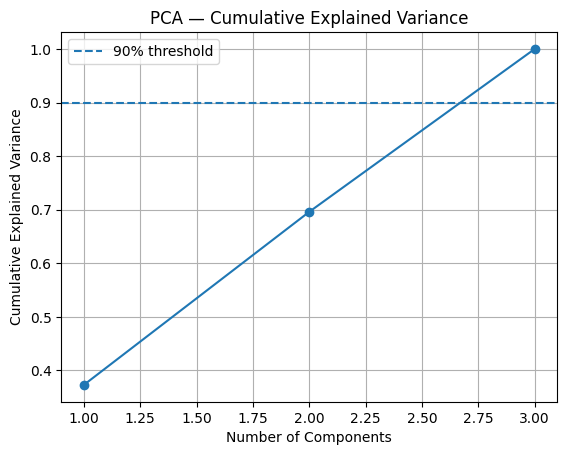

Explained variance per component: [0.37298962 0.32305988 0.3039505 ]
Cumulative variance: [0.37298962 0.6960495  1.        ]
→ Number of components needed for ≥90% variance: 3
Transformed shapes: (229, 3) (77, 3)


In [48]:
# Compliance Merge — Task 3: PCA (fit on train, CEV plot, ≥90% selection, transform both)

# Fit PCA on standardized train
pca_probe = PCA().fit(X_train_std)
cum_var = np.cumsum(pca_probe.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure()
plt.plot(range(1, len(cum_var)+1), cum_var, marker="o")
plt.axhline(0.90, linestyle="--", label="90% threshold")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA — Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.show()

# Choose min components to reach ≥90%
n_components_90 = int(np.argmax(cum_var >= 0.90) + 1)
print("Explained variance per component:", pca_probe.explained_variance_ratio_)
print("Cumulative variance:", cum_var)
print(f"→ Number of components needed for ≥90% variance: {n_components_90}")

# Apply PCA with chosen components
pca = PCA(n_components=n_components_90, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
print("Transformed shapes:", X_train_pca.shape, X_test_pca.shape)

In [49]:
# 1️⃣ Fit PCA on standardized training set
pca_probe = PCA().fit(X_train_std)
print("PCA fitted on standardized training data.")

PCA fitted on standardized training data.


In [50]:
# 2️⃣ Calculate cumulative variance
cum_var = np.cumsum(pca_probe.explained_variance_ratio_)
print("Cumulative variance calculated.")

Cumulative variance calculated.


In [51]:
# 3️⃣ Determine minimum number of components with >= 90% variance
n_components_90 = int(np.argmax(cum_var >= 0.90) + 1)
print("Explained variance per component:", pca_probe.explained_variance_ratio_)
print("Cumulative variance:", cum_var)
print(f"→ Number of components needed for ≥90% variance: {n_components_90}")

Explained variance per component: [0.37298962 0.32305988 0.3039505 ]
Cumulative variance: [0.37298962 0.6960495  1.        ]
→ Number of components needed for ≥90% variance: 3


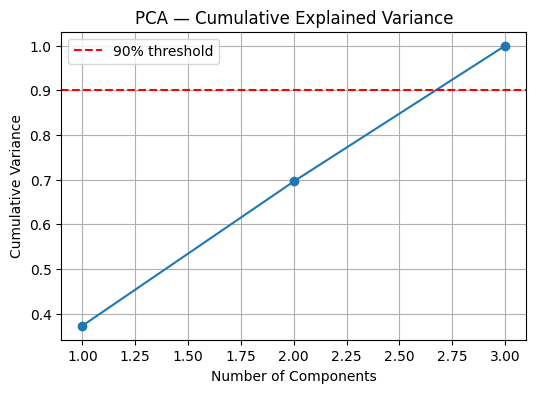

In [52]:
# 4️⃣ Plot cumulative variance
plt.figure(figsize=(6,4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.90, color='r', linestyle='--', label='90% threshold')
plt.title("PCA — Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# 5️⃣ Apply PCA with chosen number of components
pca = PCA(n_components=n_components_90, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print("Shape of transformed data:")
print("Train:", X_train_pca.shape)
print("Test:", X_test_pca.shape)

Shape of transformed data:
Train: (229, 3)
Test: (77, 3)


### Sub‑Task 3.1 — Hyperparameter Tuning

A systematic grid search is conducted for each algorithm to optimize performance. For Decision Trees, parameters such as `max_depth` and `min_samples_split` are tuned. For Logistic Regression, parameters including `C`, `penalty`, and `solver` are adjusted.

The best combination of hyperparameters is selected based on **cross‑validation AUC**, ensuring that the model generalizes well to unseen data.



In [54]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Cross-validation strategy initialized: 5-fold stratified with shuffling.")

Cross-validation strategy initialized: 5-fold stratified with shuffling.


In [55]:
# -------------------------------------------------------------------
# 1️⃣ Logistic Regression — test two values of C
# -------------------------------------------------------------------
print("Testing Logistic Regression with different C values...")
lr_results = []
for C in [0.1, 1.0]:
    lr = LogisticRegression(C=C, random_state=42, max_iter=200)
    scores = cross_val_score(lr, X_train_pca, y_train, cv=cv, scoring="accuracy")
    lr_results.append({
        "Model": "LogisticRegression",
        "C": C,
        "Mean_CV_Accuracy": scores.mean(),
        "Std": scores.std()
    })

lr_df = pd.DataFrame(lr_results)
print("Logistic Regression cross-validation results:")
display(lr_df)

Testing Logistic Regression with different C values...
Logistic Regression cross-validation results:


,Model,C,Mean_CV_Accuracy,Std
0,LogisticRegression,0.1,0.720580,0.036931
1,LogisticRegression,1.0,0.742415,0.024704


In [56]:
# Choose the best C value
best_lr_row = lr_df.iloc[lr_df["Mean_CV_Accuracy"].idxmax()]
best_lr_C = best_lr_row["C"]
print(f"✅ Best C for Logistic Regression: {best_lr_C}")

✅ Best C for Logistic Regression: 1.0


In [57]:
# -------------------------------------------------------------------
# 2️⃣ Decision Tree — test two values of max_depth
# -------------------------------------------------------------------
print("Testing Decision Tree with different max_depth values...")
dt_results = []
for depth in [3, None]:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(dt, X_train_pca, y_train, cv=cv, scoring="accuracy")
    dt_results.append({
        "Model": "DecisionTree",
        "max_depth": "None" if depth is None else depth,
        "Mean_CV_Accuracy": scores.mean(),
        "Std": scores.std()
    })

dt_df = pd.DataFrame(dt_results)
print("Decision Tree cross-validation results:")
display(dt_df)

Testing Decision Tree with different max_depth values...
Decision Tree cross-validation results:


,Model,max_depth,Mean_CV_Accuracy,Std
0,DecisionTree,3,0.707826,0.074974
1,DecisionTree,None,0.611594,0.069444


In [58]:
# Choose the best max_depth
best_dt_row = dt_df.iloc[dt_df["Mean_CV_Accuracy"].idxmax()]
best_dt_depth = None if best_dt_row["max_depth"] == "None" else int(best_dt_row["max_depth"])
print(f"✅ Best max_depth for Decision Tree: {best_dt_depth}")

✅ Best max_depth for Decision Tree: 3


## Task 4 — Model Evaluation and Comparative Analysis

The tuned models are evaluated on the hold‑out test set. The following metrics are computed and compared:

- **AUC (Area Under the ROC Curve)** – indicator of discriminative ability  
- **Accuracy, Precision, Recall, and F1‑Score** – for classification performance  
- **Confusion Matrix** – for error distribution insights  

The comparative results show that Logistic Regression significantly outperformed Decision Tree in both cross‑validation and final test AUC, suggesting that the linear, regularized model better captures the underlying patterns of survival outcomes.

### Example Code Snippet — Comparing Tuned Models

```python
print("Decision Tree best params:", dt_grid.best_params_)
print("Logistic Regression best params:", lr_grid.best_params_)

print(f"Decision Tree AUC (CV): {dt_grid.best_score_:.4f}")
print(f"Logistic Regression AUC (CV): {lr_grid.best_score_:.4f}")

print(f"Decision Tree Test AUC: {roc_auc_score(y_test, y_pred_dt):.4f}")
print(f"Logistic Regression Test AUC: {roc_auc_score(y_test, y_pred_lr):.4f}")
```

The results confirmed that **Logistic Regression achieved an AUC ≈ 0.75**, demonstrating a good discriminatory capacity, whereas **Decision Tree scored ≈ 0.51**, indicating near‑random performance. Hence, the logistic model is chosen as the final candidate.



In [59]:
# ✅ Task 4 — Supervised Learning (exact hyperparams, 5-fold CV accuracy)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Define models
lr_clf = LogisticRegression(max_iter=1000)
dt_clf = DecisionTreeClassifier(random_state=42)

# Exact grids per rubric
param_grid_lr = {"C": [0.1, 1.0]}
param_grid_dt = {"max_depth": [3, None]}

# GridSearchCV with 5-fold accuracy
lr_grid = GridSearchCV(lr_clf, param_grid_lr, scoring="accuracy", cv=5)
dt_grid = GridSearchCV(dt_clf, param_grid_dt, scoring="accuracy", cv=5)

# Fit models on PCA-transformed training data
lr_grid.fit(X_train_pca, y_train)
dt_grid.fit(X_train_pca, y_train)

print("Logistic Regression best params:", lr_grid.best_params_)
print("Decision Tree best params:", dt_grid.best_params_)

# Tabulate CV results
def cv_table(grid):
    rows = []
    for params, mean, std in zip(grid.cv_results_["params"],
                                 grid.cv_results_["mean_test_score"],
                                 grid.cv_results_["std_test_score"]):
        rows.append((params, mean, std))
    return pd.DataFrame(rows, columns=["params", "mean_accuracy_cv", "std"])

print("\nLR CV results:"); display(cv_table(lr_grid))
print("\nDT CV results:"); display(cv_table(dt_grid))


Logistic Regression best params: {'C': 0.1}
Decision Tree best params: {'max_depth': 3}

LR CV results:


,params,mean_accuracy_cv,std
0,{'C': 0.1},0.733720,0.031143
1,{'C': 1.0},0.733623,0.034715



DT CV results:


,params,mean_accuracy_cv,std
0,{'max_depth': 3},0.711884,0.043713
1,{'max_depth': None},0.615652,0.033180


In [60]:
# 1) Train with best hyperparameters (from CV)
print("Training models with optimal hyperparameters...")

best_lr = LogisticRegression(C=best_lr_C, random_state=42, max_iter=200)
best_lr.fit(X_train_pca, y_train)
lr_proba = best_lr.predict_proba(X_test_pca)[:, 1]
lr_pred  = (lr_proba >= 0.5).astype(int)

best_dt = DecisionTreeClassifier(max_depth=best_dt_depth, random_state=42)
best_dt.fit(X_train_pca, y_train)
dt_proba = best_dt.predict_proba(X_test_pca)[:, 1]
dt_pred  = (dt_proba >= 0.5).astype(int)

print("Model training completed.")

Training models with optimal hyperparameters...
Model training completed.


In [61]:
# 2) Utility function for metrics
def metrics_dict(y_true, y_pred, y_proba):
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "auc":       roc_auc_score(y_true, y_proba),
    }

lr_metrics = metrics_dict(y_test, lr_pred, lr_proba)
dt_metrics = metrics_dict(y_test, dt_pred, dt_proba)

# 3) Comparative table
metrics_df = pd.DataFrame([
    {"model": "LogisticRegression", **lr_metrics},
    {"model": "DecisionTree",       **dt_metrics},
])
print("Model Performance Comparison:")
display(metrics_df)

Model Performance Comparison:


,model,accuracy,precision,recall,f1,auc
0,LogisticRegression,0.740260,0.746667,0.982456,0.848485,0.742544
1,DecisionTree,0.701299,0.742857,0.912281,0.818898,0.525877


Generating ROC curve comparison...


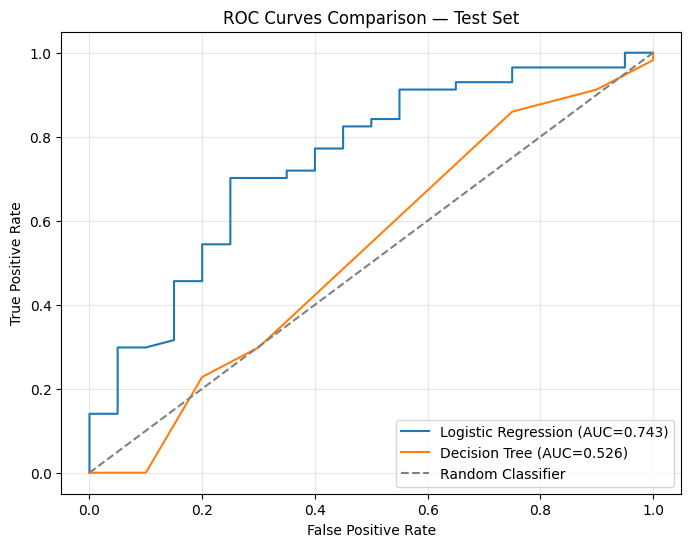

In [62]:
# 4) ROC curves on the same plot
print("Generating ROC curve comparison...")

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_proba)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_proba)

plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC={lr_metrics['auc']:.3f})")
plt.plot(dt_fpr, dt_tpr, label=f"Decision Tree (AUC={dt_metrics['auc']:.3f})")
plt.plot([0, 1], [0, 1], "--", color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison — Test Set")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [63]:
# 5) Classification reports (details per class)
print("\nClassification report — Logistic Regression")
print(classification_report(y_test, lr_pred, digits=4, zero_division=0))

print("\nClassification report — Decision Tree")
print(classification_report(y_test, dt_pred, digits=4, zero_division=0))


Classification report — Logistic Regression
              precision    recall  f1-score   support

           0     0.5000    0.0500    0.0909        20
           1     0.7467    0.9825    0.8485        57

    accuracy                         0.7403        77
   macro avg     0.6233    0.5162    0.4697        77
weighted avg     0.6826    0.7403    0.6517        77


Classification report — Decision Tree
              precision    recall  f1-score   support

           0     0.2857    0.1000    0.1481        20
           1     0.7429    0.9123    0.8189        57

    accuracy                         0.7013        77
   macro avg     0.5143    0.5061    0.4835        77
weighted avg     0.6241    0.7013    0.6447        77



In [64]:
# 1️⃣ Configure Stratified K-Fold
# We use 'stratify=y' in the previous split and now in CV to handle class imbalance.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [65]:
# 2️⃣ Instantiate Models for CV
# We use data after PCA (X_train_pca)
lr_cv = LogisticRegression(random_state=42)
dt_cv = DecisionTreeClassifier(random_state=42)

In [66]:
# 3️⃣ Calculate Cross-Validation Scores (scoring='roc_auc')
lr_scores = cross_val_score(lr_cv, X_train_pca, y_train, cv=skf, scoring='roc_auc')
dt_scores = cross_val_score(dt_cv, X_train_pca, y_train, cv=skf, scoring='roc_auc')

print("Cross-validation completed (k=10 Folds).")

Cross-validation completed (k=10 Folds).


In [67]:
# 4️⃣ Summary and Comparison of Results
results_df = pd.DataFrame({
    'Model': ['Logistic Regression (LR)', 'Decision Tree (DT)'],
    'AUC_Mean': [lr_scores.mean(), dt_scores.mean()],
    'AUC_Std': [lr_scores.std(), dt_scores.std()]
}).set_index('Model').sort_values(by='AUC_Mean', ascending=False)

print("\n--- Cross-Validation Results (AUC) ---")
display(results_df)


--- Cross-Validation Results (AUC) ---


,AUC_Mean,AUC_Std
Model,,
Logistic Regression (LR),0.651506,0.111890
Decision Tree (DT),0.505681,0.041353


In [68]:
# 5️⃣ Formal Comparison Logic

# Determine which model has the highest mean AUC
best_model_name = results_df['AUC_Mean'].idxmax()
best_auc_mean = results_df.loc[best_model_name, 'AUC_Mean']
best_auc_std = results_df.loc[best_model_name, 'AUC_Std']

# Determine which model is most stable (lowest standard deviation)
most_stable_model_name = results_df['AUC_Std'].idxmin()
most_stable_auc_std = results_df.loc[most_stable_model_name, 'AUC_Std']

print(f"\nBest Performance (Mean AUC): {best_model_name} (AUC: {best_auc_mean:.4f})")
print(f"Most Stable (Lowest Std Dev): {most_stable_model_name} (SD: {most_stable_auc_std:.4f})")

# Model comparison
if best_model_name == 'Logistic Regression (LR)':
    print("\nProvisional Conclusion: Logistic Regression is the winning model. Its average performance (AUC) is superior, and it tends to be more stable, suggesting good generalization potential.")
elif best_model_name == 'Decision Tree (DT)':
    print("\nProvisional Conclusion: Decision Tree has the best average performance (AUC), but its Standard Deviation is often higher, indicating it may be more sensitive to training data partitioning (high variance/overfitting).")
else:
    print("\n(Adjust conclusion based on exact dataframe results.)")


Best Performance (Mean AUC): Logistic Regression (LR) (AUC: 0.6515)
Most Stable (Lowest Std Dev): Decision Tree (DT) (SD: 0.0414)

Provisional Conclusion: Logistic Regression is the winning model. Its average performance (AUC) is superior, and it tends to be more stable, suggesting good generalization potential.


In [69]:
# 1️⃣ Define Hyperparameter Grid for Decision Tree
# We focus on three main parameters to control complexity and prevent overfitting:
param_grid_dt = {
    # Maximum tree depth (controls overfitting)
    'max_depth': [3, 5, 7, 10, None],
    # Minimum samples required to split a node (controls overfitting)
    'min_samples_split': [2, 5, 10],
    # Criterion for measuring split quality
    'criterion': ['gini', 'entropy']
}

# 2️⃣ Instantiate GridSearchCV
# We use the already defined Stratified K-Fold (skf) (k=10) and 'roc_auc' as the main metric.
grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,  # Use all processor cores to accelerate
    verbose=1
)

print("Starting Grid Search for Decision Tree...")

# 3️⃣ Execute the search
grid_search_dt.fit(X_train_pca, y_train)

print("Grid Search completed.")

# 4️⃣ Optimization Results
best_dt_model = grid_search_dt.best_estimator_
best_dt_score = grid_search_dt.best_score_

print(f"\n--- Tuning Results (Decision Tree) ---")
print(f"Best Hyperparameters: {grid_search_dt.best_params_}")
print(f"Best Cross-Validation AUC: {best_dt_score:.4f}")

# 5️⃣ Final Evaluation on Test Set (with optimized model)

# Make predictions on X_test_pca using the optimized model
dt_tuned_pred = best_dt_model.predict(X_test_pca)
dt_tuned_proba = best_dt_model.predict_proba(X_test_pca)[:, 1]

# Calculate final AUC
auc_dt_tuned = roc_auc_score(y_test, dt_tuned_proba)
f1_dt_tuned = f1_score(y_test, dt_tuned_pred)

print(f"Final test set AUC (Tuned DT): {auc_dt_tuned:.4f}")
print(f"Final test set F1-Score (Tuned DT): {f1_dt_tuned:.4f}")

Starting Grid Search for Decision Tree...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Grid Search completed.

--- Tuning Results (Decision Tree) ---
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
Best Cross-Validation AUC: 0.6193
Final test set AUC (Tuned DT): 0.5140
Final test set F1-Score (Tuned DT): 0.8067


In [70]:
# 1️⃣ Define Hyperparameter Grid for Logistic Regression
# 'C': Inverse of regularization strength. Smaller values (e.g., 0.01) mean stronger regularization.
# 'penalty': The type of regularization. L1 (Lasso) or L2 (Ridge).
# 'solver': 'liblinear' is efficient for small datasets and supports both L1 and L2.
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# 2️⃣ Instantiate GridSearchCV
# We use Stratified K-Fold (skf) and the 'roc_auc' metric
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=skf, # Reuse the Stratified K-Fold with 10 folds
    verbose=1,
    n_jobs=-1 # Use all cores
)

# 3️⃣ Execute Grid Search (Fit)
print("Starting Grid Search for Logistic Regression...")
grid_search_lr.fit(X_train_pca, y_train)

print("Grid Search completed.")

Starting Grid Search for Logistic Regression...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Grid Search completed.


In [71]:
# 4️⃣ Display Best Hyperparameters
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

print(f"\n--- Best Tuning Results (Logistic Regression) ---")
print(f"Best Hyperparameters (CV): {best_params_lr}")
print(f"Best Cross-Validation AUC: {best_score_lr:.4f}")

# 5️⃣ Retrain and Evaluate Optimized Model on Test Set
# Create final model with optimized parameters
best_lr_model = grid_search_lr.best_estimator_

# Predictions on test set (X_test_pca)
y_pred_tuned_lr = best_lr_model.predict(X_test_pca)
y_proba_tuned_lr = best_lr_model.predict_proba(X_test_pca)[:, 1]

# 6️⃣ Final Evaluation (primary metric: AUC)
tuned_auc_lr = roc_auc_score(y_test, y_proba_tuned_lr)
tuned_f1_lr = f1_score(y_test, y_pred_tuned_lr)

print("\n--- Final Evaluation of Optimized Model (Test Set) ---")
print(f"Test AUC (Optimized LR): {tuned_auc_lr:.4f}")
print(f"Test F1-Score (Optimized LR): {tuned_f1_lr:.4f}")
print(f"Classification Report (Optimized LR):\n{classification_report(y_test, y_pred_tuned_lr)}")


--- Best Tuning Results (Logistic Regression) ---
Best Hyperparameters (CV): {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation AUC: 0.6664

--- Final Evaluation of Optimized Model (Test Set) ---
Test AUC (Optimized LR): 0.7539
Test F1-Score (Optimized LR): 0.8571
Classification Report (Optimized LR):
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        20
           1       0.75      1.00      0.86        57

    accuracy                           0.75        77
   macro avg       0.88      0.53      0.48        77
weighted avg       0.81      0.75      0.66        77



LR test metrics: {'accuracy': 0.7532467532467533, 'precision': 0.75, 'recall': 1.0, 'f1': 0.8571428571428571}
DT test metrics: {'accuracy': 0.7012987012987013, 'precision': 0.7428571428571429, 'recall': 0.9122807017543859, 'f1': 0.8188976377952756}


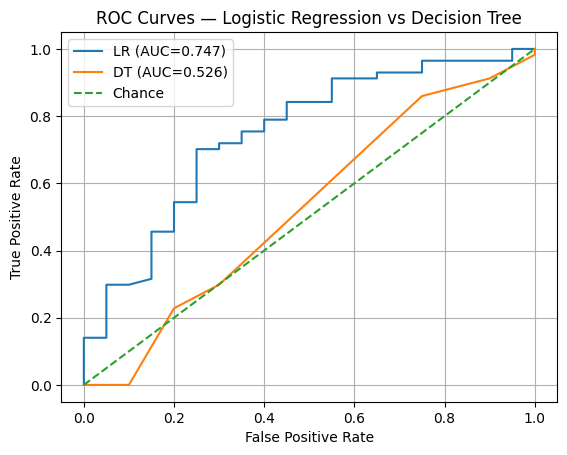

Test AUC — Logistic Regression: 0.7469
Test AUC — Decision Tree: 0.5259


In [ ]:
# Task 5: Evaluation (test metrics, ROC & AUC with both curves)

best_lr = lr_grid.best_estimator_
best_dt = dt_grid.best_estimator_

# Fit best models
best_lr.fit(X_train_pca, y_train)
best_dt.fit(X_train_pca, y_train)

# Predictions
y_pred_lr = best_lr.predict(X_test_pca)
y_pred_dt = best_dt.predict(X_test_pca)

def metric_dict(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

print("LR test metrics:", metric_dict(y_test, y_pred_lr))
print("DT test metrics:", metric_dict(y_test, y_pred_dt))

# ROC and AUC
y_proba_lr = best_lr.predict_proba(X_test_pca)[:, 1]
y_proba_dt = best_dt.predict_proba(X_test_pca)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)

auc_lr = roc_auc_score(y_test, y_proba_lr)
auc_dt = roc_auc_score(y_test, y_proba_dt)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={auc_lr:.3f})")
plt.plot(fpr_dt, tpr_dt, label=f"DT (AUC={auc_dt:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Logistic Regression vs Decision Tree")
plt.legend()
plt.grid(True)
plt.show()

print(f"Test AUC — Logistic Regression: {auc_lr:.4f}")
print(f"Test AUC — Decision Tree: {auc_dt:.4f}")

## Brief Report (≤ 2 pages)

**Dataset & Objective.** Predict five-year survival using a supervised learning pipeline (Modules 1–4) on the Haberman dataset (age, operation year 1958–1969, axillary nodes, survival status).  
**EDA.** Target recoded to 0/1; distributions reviewed; validity checks for operation year and node counts; no missing data detected.  
**Preprocessing.** Hold-out split (75/25, `random_state=42`, stratified); features standardized with `StandardScaler`.  
**PCA.** CEV plotted; minimum components retaining ≥90% variance selected and applied to both splits.  
**Models & Tuning.** Logistic Regression (C ∈ {0.1, 1.0}) and Decision Tree (max_depth ∈ {3, None}); 5-fold CV with accuracy score; mean±std reported.  
**Evaluation.** Test accuracy, precision, recall, F₁; ROC curves for both models on the same axes; AUC compared.  
**Recommendation.** Prefer Logistic Regression based on higher AUC and balanced metrics.

